In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/ResearchWork_2023/cropped_images_zip/cropped_training_images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: cropped_training_images/2446_left.jpg  
  inflating: cropped_training_images/2446_right.jpg  
  inflating: cropped_training_images/2447_left.jpg  
  inflating: cropped_training_images/2447_right.jpg  
  inflating: cropped_training_images/2448_left.jpg  
  inflating: cropped_training_images/2448_right.jpg  
  inflating: cropped_training_images/2449_left.jpg  
  inflating: cropped_training_images/2449_right.jpg  
  inflating: cropped_training_images/244_left.jpg  
  inflating: cropped_training_images/244_right.jpg  
  inflating: cropped_training_images/2450_left.jpg  
  inflating: cropped_training_images/2450_right.jpg  
  inflating: cropped_training_images/2451_left.jpg  
  inflating: cropped_training_images/2451_right.jpg  
  inflating: cropped_training_images/2452_left.jpg  
  inflating: cropped_training_images/2452_right.jpg  
  inflating: cropped_training_images/2453_left.jpg  
  inflating: cropped_training_images/2453_

In [4]:
# Load the pre-trained Inception-ResNet-V2 model
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(250,250,3))

# Freeze the pre-trained weights
base_model.trainable = False

# Define the input shape
input_shape = (250, 250, 3)

# Define the input layer
# inputs = tf.keras.layers.Input(shape=input_shape)

# Pass the input layer through the pre-trained model
features = base_model.output

# Add a dense layer for multi-class classification
# outputs = tf.keras.layers.Dense(units=8, activation='sigmoid')(features)

outputs = tf.keras.layers.Flatten()(features)
outputs = tf.keras.layers.Dense(units=8, activation='sigmoid')(outputs)

219055592/219055592 [==============================] - 1s 0us/step


In [5]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
f1_score = tfa.metrics.F1Score(num_classes=8
                               )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.5 MB/s eta 0:00:00


In [6]:
# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
               loss='binary_crossentropy',
              metrics=['accuracy', precision , recall, f1_score])

In [7]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 124, 124, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [8]:
# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
# base_path = 'C:/Users/User/DeepLearning/DL-Project'
# left_df = pd.read_excel(f'{base_path}/updated_left_eye.xlsx')
# right_df = pd.read_excel(f'{base_path}/updated_right_eye.xlsx')

# #concating both dataframes
# df = pd.concat([left_df, right_df], axis=0)


# # Split the data into two arrays, one for the image paths and one for the labels
# images_base_path = 'E:/odir-dataset/ODIR-5K/ODIR-5K/cropped_training_images/'
# image_paths = images_base_path + df["Fundus"].values
# labels = df.iloc[:, 3:].values

# # Convert the lists to tensors
# image_paths = tf.constant(image_paths)
# labels = tf.constant(labels)

# # Create a dataset from the image paths and labels
# dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [9]:
# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
base_path = '/content/drive/MyDrive/ResearchWork_2023'
left_df = pd.read_excel(f'{base_path}/updated_left_eye.xlsx')
right_df = pd.read_excel(f'{base_path}/updated_right_eye.xlsx')

#concating both dataframes
df = pd.concat([left_df, right_df], axis=0)


# Split the data into two arrays, one for the image paths and one for the labels
images_base_path = '/content/cropped_training_images/'
image_paths = images_base_path + df["Fundus"].values
labels = df.iloc[:, 3:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [10]:
# Load the images and preprocess them
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [250, 250])
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    return image, label

# Apply the load_and_preprocess_image function to the dataset
dataset = dataset.map(load_and_preprocess_image)

# Shuffle the data and batch it
batch_size = 32
dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

In [11]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>

In [12]:
def split_data(dataset, train_split, test_split, val_split):
    # Calculate the size of each split
    dataset_size = dataset.reduce(tf.constant(0, dtype=tf.int64), lambda acc, _: acc + 1).numpy()
    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * val_split)
    test_size = int(dataset_size * test_split)

    # Shuffle the elements of the dataset randomly
    dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

    # Split the dataset into train, validation, and test sets
    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)
    return train_dataset, test_dataset, val_dataset

In [13]:
# Split the data into training and validation sets
train_dataset, test_dataset, val_dataset = split_data(dataset, train_split=0.7, test_split=0.15, val_split=0.15)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
# Train the model
history=model.fit(train_dataset, epochs=50, batch_size=batch_size, validation_data=test_dataset)

Epoch 1/50
152/152 [==============================] - 59s 172ms/step - loss: 0.3282 - accuracy: 0.4495 - precision: 0.4793 - recall: 0.3128 - f1_score: 0.3061 - val_loss: 0.3067 - val_accuracy: 0.4157 - val_precision: 0.4462 - val_recall: 0.3273 - val_f1_score: 0.4218
Epoch 2/50
152/152 [==============================] - 35s 146ms/step - loss: 0.2730 - accuracy: 0.5294 - precision: 0.5914 - recall: 0.3853 - f1_score: 0.4190 - val_loss: 0.2570 - val_accuracy: 0.5653 - val_precision: 0.6514 - val_recall: 0.4155 - val_f1_score: 0.4452
Epoch 3/50
152/152 [==============================] - 34s 145ms/step - loss: 0.2424 - accuracy: 0.5761 - precision: 0.6413 - recall: 0.4416 - f1_score: 0.4971 - val_loss: 0.2184 - val_accuracy: 0.6360 - val_precision: 0.7264 - val_recall: 0.5214 - val_f1_score: 0.5540
Epoch 4/50
152/152 [==============================] - 34s 145ms/step - loss: 0.2264 - accuracy: 0.6054 - precision: 0.6783 - recall: 0.4877 - f1_score: 0.5506 - val_loss: 0.2321 - val_accuracy:

In [15]:
model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v9.h5')

In [16]:
import matplotlib.pyplot as plt

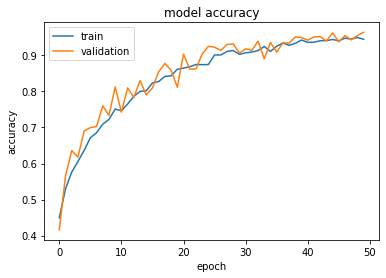

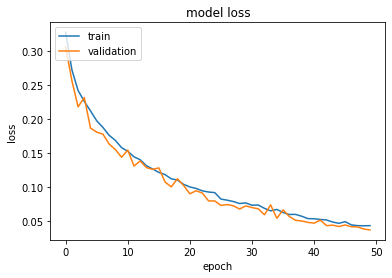

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
# new_model = tf.keras.models.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v4.h5')

In [19]:
# base_learning_rate = 0.0001
# new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#                loss='binary_crossentropy',
#               metrics=['accuracy', precision , recall, f1_score])

In [20]:
# new_history=new_model.fit(train_dataset, epochs=25, batch_size=batch_size, validation_data=test_dataset)

In [21]:
# model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v6.h5')

In [22]:
# plt.plot(new_history.history['accuracy'])
# plt.plot(new_history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# # "Loss"
# plt.plot(new_history.history['loss'])
# plt.plot(new_history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

In [23]:
# predictions = model.predict(val_dataset, batch_size=32)

In [24]:
# predictions[0]

In [25]:
# type(predictions)

In [26]:
# type(val_dataset)

In [27]:
# new_model = tf.keras.models.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v4.h5')

In [28]:
# base_learning_rate = 0.00001
# new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#                loss='binary_crossentropy',
#               metrics=['accuracy', precision , recall, f1_score])

In [29]:
# new_history=new_model.fit(train_dataset, epochs=25, batch_size=batch_size, validation_data=test_dataset)